In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

Let us consider the problem 
$$\frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2} + v\frac{\partial u}{\partial x}$$

subject to $u(0) = u(L) = 0$.

We 

In [4]:
Q = 150  # m/s^3
A = 2000 # m^2
k = 400
kappa = k
R = 10000
L = 10000

pi = np.pi

a = A/pi

In [5]:
from scipy.special import jv
from scipy.special import yv

order = (Q/pi)/(2*kappa)

from scipy.optimize import root

In [6]:
def phi_bessel(r,par):
    return (r)**(order)*jv(order, np.sqrt(par[0]/kappa)*(r)) + par[1]*(r)**(order)*yv(order, np.sqrt(par[0]/kappa)*(r))


In [7]:
good_roots_bessel = np.array([[3.94030436e-05,7.61848195e-01], #n=0
                              [1.71476791e-04,1.36154281e+00], #n=1
                              [3.94842613e-04,2.49685017e+00], #n=2
                              [7.08883157e-04,6.97900847e+00], #n=3
                              [1.11333787e-03,-1.12220582e+01], #n=4
                              [1.60807412e-03,-3.06309775e+00], #n=5
                              [2.19302e-03,-1.67100131e+00], #n=6
                              [2.86812e-03,-1.05017646e+00], #n=7
                              [3.63335e-03,-0.66912985e+00], #n=8
                              [4.4887e-03,-0.38862351e+00], #n=9
                              [5.43415e-03,-0.15366476e+00], #n=10
                              [6.46968e-03,0.065137e+00], #n=11
                              [7.5953e-03,0.2897497e+00], #n=12
                              [8.81099e-03,0.54445193e+00], #n=13
                              [1.011676e-02,0.86784664e+00], #n=14
                              [1.15126e-02,1.34271697e+00], #n=15
                              [1.29985e-02,2.21252377e+00], #n=16
                              [1.457447e-02,4.71344792e+00], #n=17
                              [1.62405098e-02,-2.61426615e+02], #n=18
                              [1.799661e-02,-4.44488786e+00]]) #n=20


In [13]:
N_r = 15 #len(good_roots_bessel)
N_x = 20

def phi_r_n(r,n):
    return phi_bessel(r, good_roots_bessel[n-1])

def labda_r_n(n):
    return good_roots_bessel[n-1][0]

def phi_x_n(x,n):
    return np.exp(-Q/(2*k*A)*x)*np.sin(n*pi*x/L)

def labda_x_n(n):
    return (Q/A)**2/(4*k) + k*(n*pi/L)**2

In [26]:
dt = 1e-3
t = np.arange(0,1e-2,dt)

## Final solution
Now that we have the eigenfunctions and $f(t)$ is approximated, we will build the final solution.  
  
First we linearly interpolate the discrete solution for $f(t)$:

In [27]:
# Guess
time_constant = min(labda_r_n(1), labda_x_n(1))
time_constant = 1e0
def f_interp(T):
    eq1 = (a/R)**(0.5*Q/(kappa*pi))
    eq2 = (a/R)**(Q/(kappa*pi))
    return 0# eq1 +(eq2-eq1)*np.exp(-T/t[-1])

def f_prime_interp(T):
    eq1 = (a/R)**(0.5*Q/(kappa*pi))
    eq2 = (a/R)**(Q/(kappa*pi))
    return 0#-t[-1]*(eq2-eq1)*np.exp(-T/t[-1])

Now we calulate $s(x,t)$ and $\zeta(x,t)$:

In [46]:
def psi(r,t):
    return (f_interp(t)-1)/(a-R)*r + (R*f_interp(t)-a)/(R-a)

def xi(x,t):
    return f_interp(t)*(1-x/L)


def ss_x(x):
    return (a/R)**(0.5*Q/(kappa*pi))*(1-x/L) * np.exp(-x/L)
    return (a/R)**(0.5*Q/(kappa*pi))*np.exp(-0.5*Q*x/(k*A))

def ss_r(r):
    #return (1-(a/R)**(0.5*Q/(kappa*pi)))/(R-a)*r + 1-R*(1-(a/R)**(0.5*Q/(kappa*pi)))/(R-a)
    return (r/R)**(0.5*Q/(kappa*pi))

def u(x):
    return np.exp(-Q/(2*k*A)*x)*np.sin(pi*x/L)
    return ss_x(x) - xi(x,0)

def v(r):
    return ss_r(r) - psi(r,0)

In [58]:
def H(r,t):
    psi_t = f_prime_interp(t)*r/(a-R) + R*f_prime_interp(t)/(R-a)
    psi_rr = 0
    psi_r = (f_interp(t)-1)/(a-R)
    return -psi_t + kappa*psi_rr + (kappa-Q/pi)/r*psi_r

def Lf(x,t):
    xi_t = f_prime_interp(t)*(1-x/L)
    xi_xx = 0
    xi_x = -f_interp(t)/L
    return 0 -xi_t + k*xi_xx + Q/A*xi_x


def h(tau):
    return np.array([integrate.quad(lambda r: H(r,tau)*phi_r_n(r,n), a, R)[0] for n in range(1,N_r)])

def l(tau):
    return np.array([integrate.quad(lambda x: Lf(x,tau)*phi_x_n(x,n), 0, L)[0] for n in range(1,N_x)])

def inner_x(n,m):
    return integrate.quad(lambda x: phi_x_n(x,m)*phi_x_n(x,n), 0, L)[0]

def inner_r(n,m):
    return integrate.quad(lambda r: phi_r_n(r,m)*phi_r_n(r,n), a, R)[0]

G_x = np.array([[inner_x(n,m) for n in range(1,N_x)] for m in range(1,N_x)])
G_r = np.array([[inner_r(n,m) for n in range(1,N_r)] for m in range(1,N_r)])

labda_x = np.array([labda_x_n(n) for n in range(1,N_x)])
labda_r = np.array([labda_r_n(n) for n in range(1,N_r)])

inv_x = np.linalg.inv(G_x)
inv_r = np.linalg.inv(G_r)


T0_r = inv_r @ np.array([integrate.quad(lambda r: v(r)*phi_r_n(r,n), a, R)[0] for n in range(1,N_r)])
T0_x = inv_x @ np.array([integrate.quad(lambda x: u(x)*phi_x_n(x,n), 0, L)[0] for n in range(1,N_x)])
# def T_x(t):
#     return np.exp(-labda_x*t)*T0_x + np.exp(-labda_x*t) * np.array([integrate.quad(lambda tau: (inv_x @ l(tau)*np.exp(labda_x*tau))[i], 0, t)[0] for i in range(0,N_x-1)])

# def T_r(t):
#     return np.exp(-labda_r*t)*T0_r + np.exp(-labda_r*t) * np.array([integrate.quad(lambda tau: (inv_r @ h(tau)*np.exp(labda_r*tau))[i], 0, t)[0] for i in range(0,N_r-1)])


def T_x(t):
    return np.exp(-labda_x*t)*T0_x + np.exp(-labda_x*t) * np.array(integrate.quad_vec(lambda tau: np.exp(labda_x*tau) * (inv_x @ l(tau)), 0, t)[0])

def T_r(t):
    return np.exp(-labda_r*t)*T0_r + np.exp(-labda_r*t) * integrate.quad_vec(lambda tau: (inv_r @ h(tau) )*np.exp(labda_r*tau), 0, t)[0]


def sol_r(r,t):
    res = T_r(t) @ np.array([phi_r_n(r,n) for n in range(1,N_r)])
    return res + psi(r,t)

def sol_x(x,t):
    res = T_x(t) @ np.array([phi_x_n(x,n) for n in range(1,N_x)])
    return res #+ xi(x,t)

In [59]:
x = np.linspace(0,L,100)
# r = np.linspace(a,R,100)

# ax = np.append(-x[::-1], r)
# res = np.append(sol_x(x,t[0])[::-1], sol_r(r,t[0]))

# plt.figure(figsize=(12,12))
# plt.plot(ax, res)
# for i in range(0,len(t), 10):
#     print(i)
#     res = np.append(sol_x(x,t[i])[::-1], sol_r(r,t[i]))
#     plt.plot(ax, res, label=str(t[i]))
#     plt.plot(0, f_interp(t[i]), 'r.')
# plt.legend()
# plt.show()

0
1
2
3
4
5
6
7
8
9


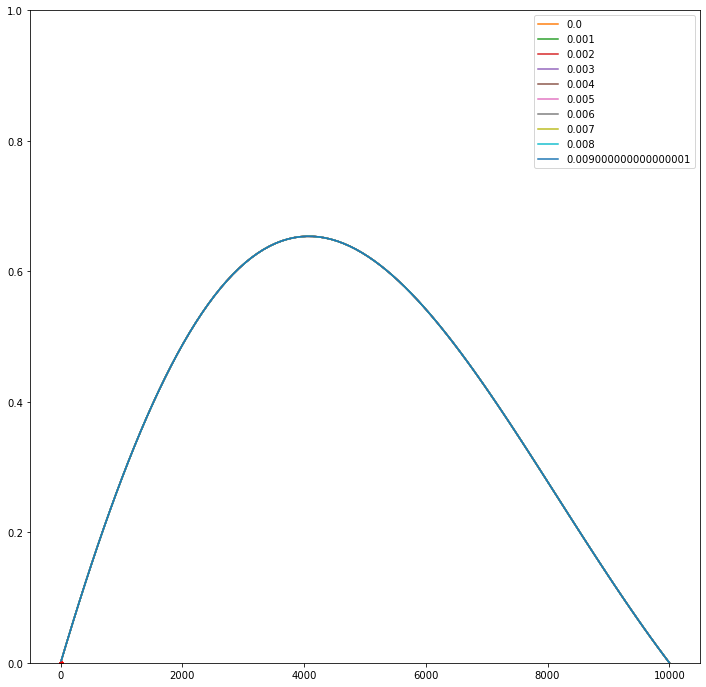

In [60]:
plt.figure(figsize=(12,12))
plt.plot(x,u(x), '--')
for i in range(0,len(t), 1):
    print(i)
    plt.plot(x, sol_x(x,t[i]), label=str(t[i]))
    plt.plot(0, f_interp(t[i]), 'r.')
    plt.ylim(0,1)
plt.legend()
plt.show()

In [61]:
U = np.array([1,2])
P = np.array([[7,3],[1,4]])

print(U)
print(P)
print(P @ U)

[1 2]
[[7 3]
 [1 4]]
[13  9]


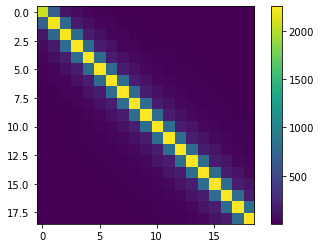

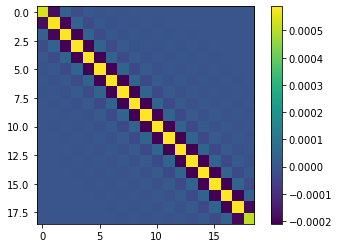

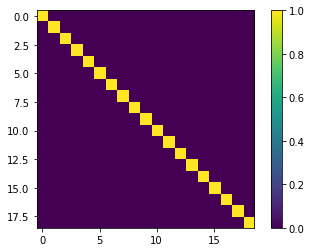

In [62]:
plt.figure()
plt.imshow(G_x)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(inv_x)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(G_x @ inv_x)
plt.colorbar()
plt.show()

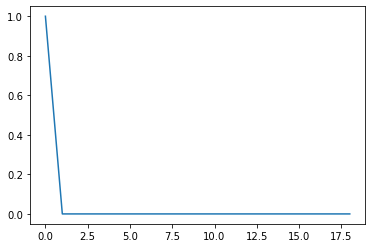

[ 1.00000000e+00 -9.36750677e-17  5.55111512e-17 -1.38777878e-17
  1.04083409e-17  4.33680869e-18  2.60208521e-18 -1.30104261e-18
 -1.30104261e-18  3.25260652e-19 -2.16840434e-19  1.08420217e-19
 -1.08420217e-19  1.08420217e-19  0.00000000e+00  3.25260652e-19
 -1.08420217e-19 -1.08420217e-19 -5.42101086e-20]
[ 9.99957007e-01 -9.36599470e-17  5.54912362e-17 -1.38689758e-17
  1.03980367e-17  4.33063427e-18  2.59704737e-18 -1.29775496e-18
 -1.29688428e-18  3.23977967e-19 -2.15806323e-19  1.07805230e-19
 -1.07698883e-19  1.07584146e-19  0.00000000e+00  3.21988837e-19
 -1.07189876e-19 -1.07041869e-19 -5.34428133e-20]


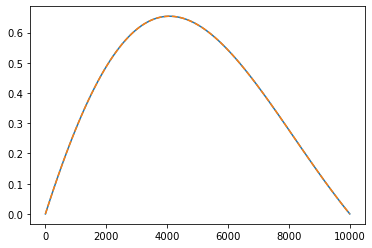

In [63]:
plt.figure()
plt.plot(T0_x)
plt.show()
print(T_x(0))
print(T_x(1))

Y = inv_x @ np.array([integrate.quad(lambda x: u(x)*phi_x_n(x,n), 0, L)[0] for n in range(1,N_x)])

plt.figure()
plt.plot(x, Y @ np.array([phi_x_n(x,i) for i in range(1,N_x)]))
plt.plot(x, u(x), '--')
plt.show()